## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [44]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras import optimizers
from keras.utils import img_to_array, load_img
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
# from keras import applications
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Loading up our image datasets

In [45]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.weights.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 20 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 10  

In [46]:
#Loading vgc16 model
#vgg16 = applications.ResNet50(include_top=False, weights='imagenet') 
vgg16 = ResNet50(include_top=False, weights='imagenet')

In [47]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [48]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1517 images belonging to 20 classes.


C:\Users\Pawan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 68s 440ms/step
Time:  0:01:09.591505


In [49]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [50]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 164 images belonging to 20 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step
Time:  0:00:07.750969


In [51]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [52]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 164 images belonging to 20 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step
Time:  0:00:07.590736


# Loading training, validation and testing data

In [53]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 1517 images belonging to 20 classes.


In [54]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 164 images belonging to 20 classes.


In [55]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 164 images belonging to 20 classes.


# Training of model

In [56]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(negative_slope=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(negative_slope=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

C:\Users\Pawan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - acc: 0.0492 - loss: 4.2749 - val_acc: 0.0732 - val_loss: 3.2070
Epoch 2/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - acc: 0.0512 - loss: 3.6026 - val_acc: 0.0854 - val_loss: 3.1695
Epoch 3/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - acc: 0.0908 - loss: 3.4486 - val_acc: 0.1098 - val_loss: 2.8797
Epoch 4/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - acc: 0.0857 - loss: 3.3795 - val_acc: 0.0610 - val_loss: 2.9753
Epoch 5/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - acc: 0.1185 - loss: 3.2906 - val_acc: 0.0915 - val_loss: 3.1225
Epoch 6/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - acc: 0.1015 - loss: 3.3454 - val_acc: 0.1402 - val_loss: 2.7497
Epoch 7/7
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - acc: 0.1230 - loss: 3.1781 - val_acc: 0.1646 - val_loss: 2.7277
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1089 - loss: 2.7798
[INFO] accuracy: 16.46%
[INFO] Loss: 2.7277274131774902
Time:  0:01:58.815622


In [26]:
#Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │    10,035,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         1,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,082,742 (76.61 MB)

 Trainable params: 10,041,370 (38.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,041,372 (38.30 MB)

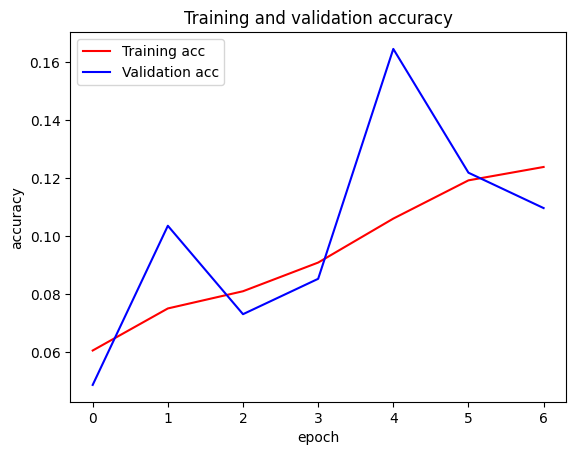

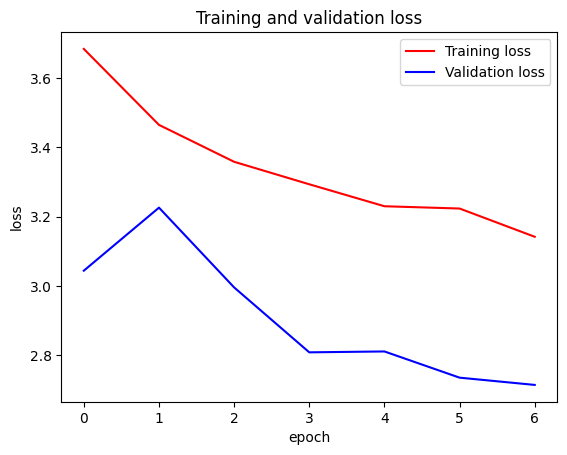

In [27]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [28]:
model.evaluate(test_data, test_labels)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1300 - loss: 2.6863


[2.507967233657837, 0.15243902802467346]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [29]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.         0.         0.         ... 3.1976345  0.
    0.        ]
   [0.         0.         0.         ... 2.356658   0.
    0.        ]
   [0.         0.         0.         ... 2.3831694  0.
    0.        ]
   ...
   [0.         0.         0.3568579  ... 3.068329   0.
    0.        ]
   [0.         0.         0.25760436 ... 2.6061814  0.
    0.        ]
   [0.         0.         0.         ... 3.727749   0.
    0.        ]]

  [[0.         0.         0.         ... 0.3079003  0.
    0.        ]
   [0.         0.         0.         ... 2.3574607  0.
    0.        ]
   [0.         0.         0.         ... 1.3450732  0.
    0.        ]
   ...
   [0.         0.         0.         ... 2.2197487  0.
    0.        ]
   [0.         0.         0.         ... 2.6582558  0.
    0.        ]
   [0.         0.         0.         ... 1.642076   0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.828111

In [31]:
animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        10
      cougar       0.00      0.00      0.00        10
      coyote       0.00      0.00      0.00        10
         cow       0.00      0.00      0.00        10
  crocodiles       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00        10
    elephant       0.00      0.00      0.00        10
     giraffe       0.00      0.00      0.00         6
        goat       0.00      0.00      0.00         9
     gorilla       0.00      0.00      0.00         6
       horse       0.00      0.00      0.00        10
    kangaroo       0.00      0.00      0.00         7
     leopard       0.00      0.00      0.00        10
        lion       0.00      0.00      0.00         9
       panda       0.00      0.00      0.00         8
     penguin       1.00      0.20      0.33         5
       sheep       0.00      0.00      0.00         5
       skunk       0.00    

C:\Users\Pawan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pawan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

In [32]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [33]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8)):  # Adjust the figsize as per your preference
    # Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    # Set figure size
    plt.figure(figsize=figsize)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    # Rotate x-labels by 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Increase x-coordinate for more horizontal space
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


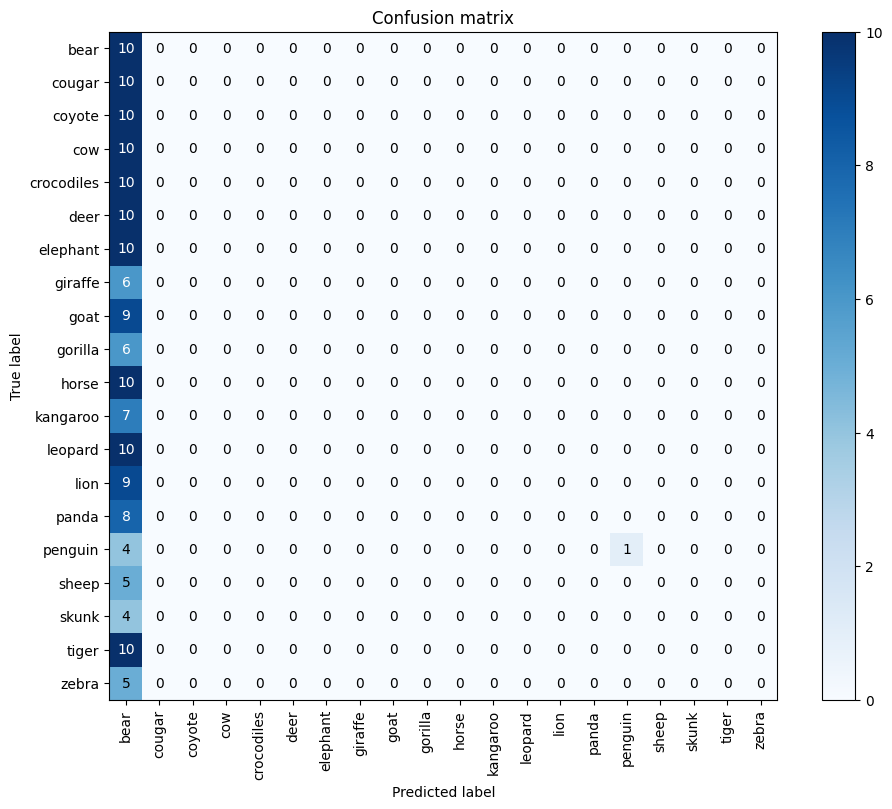

In [38]:
plot_confusion_matrix(confusion_matrix, ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'])

Normalized confusion matrix


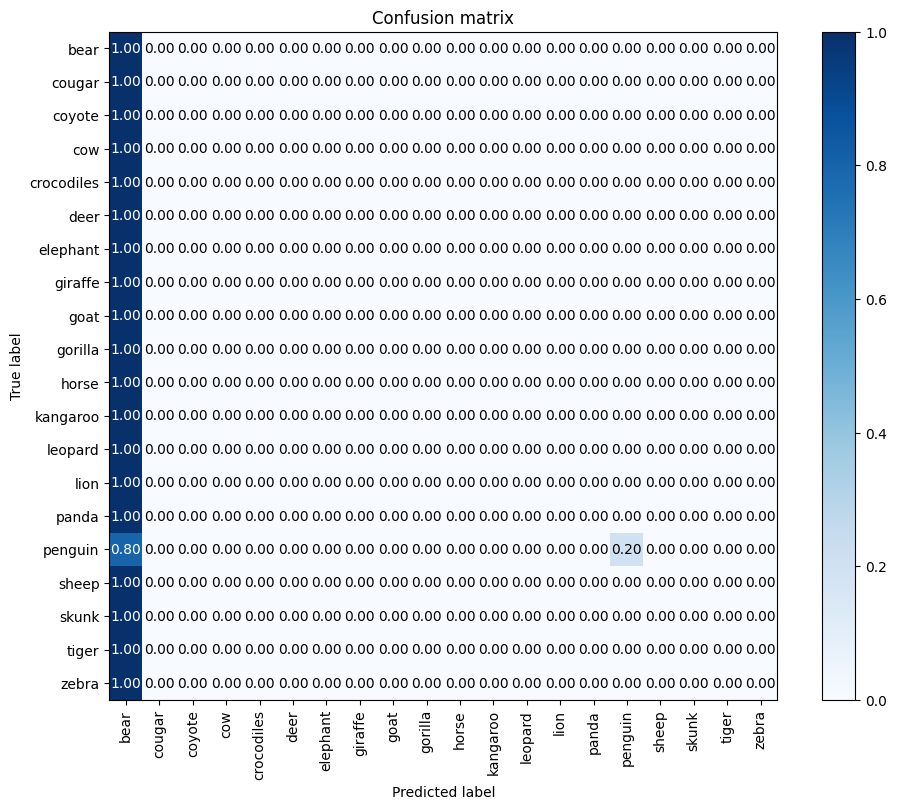

In [39]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'],
                     normalize=True)

## Testing images on model

In [40]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [41]:
def test_single_image(path):
    animals = ['butterflies', 'chickens',
               'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    #print("BT ",bt_prediction)
    for idx, animal, x in zip(range(0, 6), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100, 2)))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    class_dictionary = generator_top.class_indices
    #print("class_dictionary ",class_dictionary)
    inv_map = {v: k for k, v in class_dictionary.items()}
    #print("inv_map ",inv_map)
    class_prob = list(class_predicted[0])
    #print(class_prob)
    max_prob = max(class_prob)
    #print(max_prob)
    pred_class = class_prob.index(max_prob)
    #print(pred_class)
    print("ID: {}, Label: {}".format(class_dictionary[inv_map[pred_class]], inv_map[pred_class]))
    return load_img(path)

In [42]:
path = 'data/test/elephant/5680.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ID: 0, Label: butterflies 10.92%
ID: 1, Label: chickens 4.72%
ID: 2, Label: elephants 1.91%
ID: 3, Label: horses 22.66%
ID: 4, Label: spiders 2.8%
ID: 5, Label: squirells 3.62%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
ID: 3, Label: coyote


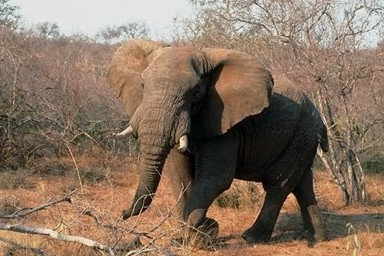

In [43]:
test_single_image(path)